## Imports

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings("ignore")

# Load and display dataset.

In [8]:
# Load dataset
data_path = "Data/amazon_sale_report.csv"
df = pd.read_csv(data_path, encoding="latin1")

# Display dataset info
df.info()

# Show first few rows
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128975 entries, 0 to 128974
Data columns (total 24 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   index               128975 non-null  int64  
 1   Order ID            128975 non-null  object 
 2   Date                128975 non-null  object 
 3   Status              128975 non-null  object 
 4   Fulfilment          128975 non-null  object 
 5   Sales Channel       128975 non-null  object 
 6   ship-service-level  128975 non-null  object 
 7   Style               128975 non-null  object 
 8   SKU                 128975 non-null  object 
 9   Category            128975 non-null  object 
 10  Size                128975 non-null  object 
 11  ASIN                128975 non-null  object 
 12  Courier Status      122103 non-null  object 
 13  Qty                 128975 non-null  int64  
 14  currency            121180 non-null  object 
 15  Amount              121180 non-nul

,index,Order ID,Date,Status,Fulfilment,Sales Channel,ship-service-level,Style,SKU,Category,...,currency,Amount,ship-city,ship-state,ship-postal-code,ship-country,promotion-ids,B2B,fulfilled-by,Unnamed: 22
0,0,405-8078784-5731545,04-30-22,Cancelled,Merchant,Amazon.in,Standard,SET389,SET389-KR-NP-S,Set,...,INR,647.62,MUMBAI,MAHARASHTRA,400081.0,IN,NaN,False,Easy Ship,NaN
1,1,171-9198151-1101146,04-30-22,Shipped - Delivered to Buyer,Merchant,Amazon.in,Standard,JNE3781,JNE3781-KR-XXXL,kurta,...,INR,406.00,BENGALURU,KARNATAKA,560085.0,IN,Amazon PLCC Free-Financing Universal Merchant ...,False,Easy Ship,NaN
2,2,404-0687676-7273146,04-30-22,Shipped,Amazon,Amazon.in,Expedited,JNE3371,JNE3371-KR-XL,kurta,...,INR,329.00,NAVI MUMBAI,MAHARASHTRA,410210.0,IN,IN Core Free Shipping 2015/04/08 23-48-5-108,True,NaN,NaN
3,3,403-9615377-8133951,04-30-22,Cancelled,Merchant,Amazon.in,Standard,J0341,J0341-DR-L,Western Dress,...,INR,753.33,PUDUCHERRY,PUDUCHERRY,605008.0,IN,NaN,False,Easy Ship,NaN
4,4,407-1069790-7240320,04-30-22,Shipped,Amazon,Amazon.in,Expedited,JNE3671,JNE3671-TU-XXXL,Top,...,INR,574.00,CHENNAI,TAMIL NADU,600073.0,IN,NaN,False,NaN,NaN


## Data Preprocessing & Feature Engineering.

In [9]:
# Convert Date column to datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%m-%d-%y')

# Aggregate daily sales
df = df[['Date', 'Amount']].groupby('Date').sum().reset_index()

# Feature Engineering: Add seasonality indicators
df['day_of_week'] = df['Date'].dt.dayofweek
df['month'] = df['Date'].dt.month
df['year'] = df['Date'].dt.year
df['quarter'] = df['Date'].dt.quarter

# Set Date as index and fill missing values
df = df.set_index('Date').asfreq('D').fillna(method='ffill')

# Display processed data
df.head()

,Amount,day_of_week,month,year,quarter
Date,,,,,
2022-03-31,101683.85,3,3,2022,1
2022-04-01,865478.60,4,4,2022,2
2022-04-02,913101.53,5,4,2022,2
2022-04-03,1011763.38,6,4,2022,2
2022-04-04,882059.17,0,4,2022,2


# Exploratory Data Analysis (EDA)
will analyze sales trends, seasonality, and distribution.

## lijndiagram (line chart)

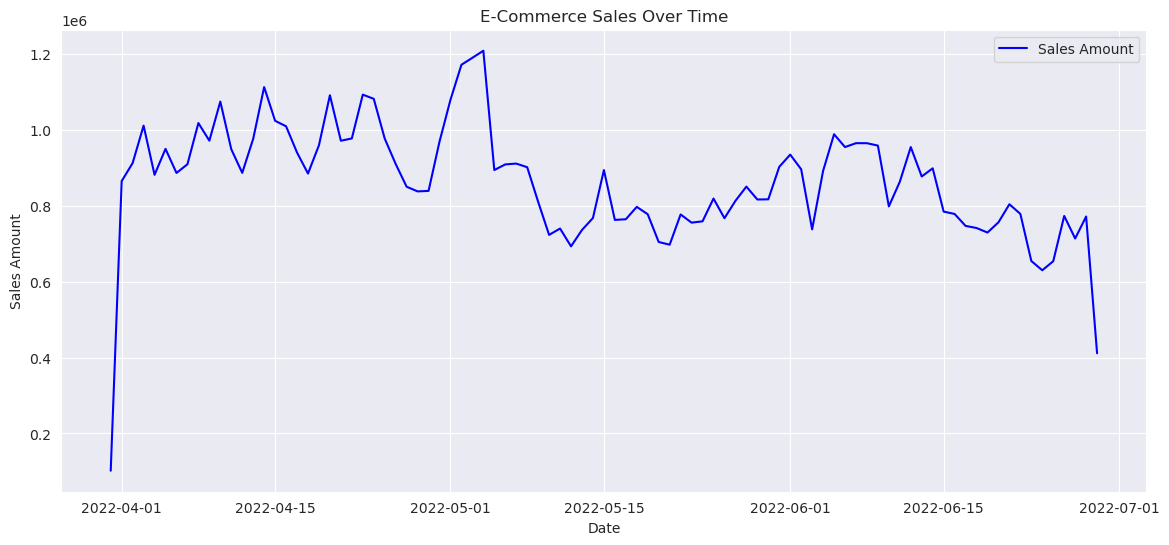

In [10]:
# Plot overall sales trend
plt.figure(figsize=(14,6))
plt.plot(df['Amount'], label="Sales Amount", color='b')
plt.title("E-Commerce Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Sales Amount")
plt.legend()
plt.show()

## boxplot (doosdiagram)

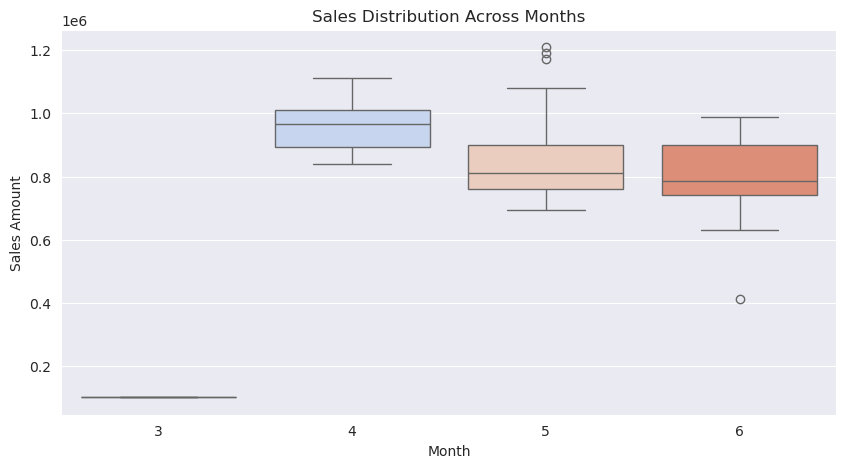

In [11]:
# Monthly Sales Analysis
plt.figure(figsize=(10,5))
sns.boxplot(x=df['month'], y=df['Amount'], palette="coolwarm")
plt.title("Sales Distribution Across Months")
plt.xlabel("Month")
plt.ylabel("Sales Amount")
plt.show()

## staafdiagram (bar chart)

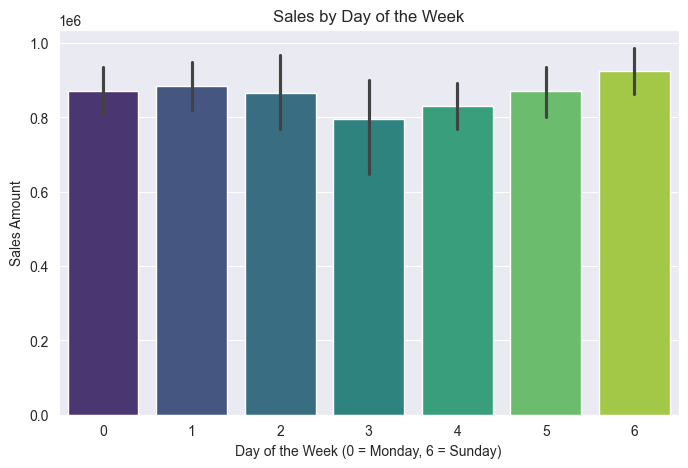

In [8]:
# Day-of-week Sales
plt.figure(figsize=(8,5))
sns.barplot(x=df['day_of_week'], y=df['Amount'], palette="viridis")
plt.title("Sales by Day of the Week")
plt.xlabel("Day of the Week (0 = Monday, 6 = Sunday)")
plt.ylabel("Sales Amount")
plt.show()

## Train-Test Split & Scaling.
split the data into 80% training and 20% testing sets.
LSTM requires data scaling for better convergence.

In [14]:
# Splitting Data
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]

# Scaling Data for LSTM
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train[['Amount']])
test_scaled = scaler.transform(test[['Amount']])

# Display dataset size
print(f"Training Data: {len(train)} rows, Testing Data: {len(test)} rows")

Training Data: 72 rows, Testing Data: 19 rows


## SARIMA Model
SARIMA is a time-series model that accounts for seasonality.

In [13]:
# Train SARIMA Model
sarima_model = SARIMAX(train['Amount'], order=(3,1,2), seasonal_order=(2,1,2,12))
sarima_fit = sarima_model.fit()

# Forecast
sarima_preds = sarima_fit.forecast(steps=len(test))

# Ensure both values have the same shape for evaluation
sarima_mae = (test['Amount'], sarima_preds)
sarima_rmse = np.sqrt(mean_squared_error(test['Amount'], sarima_preds))
sarima_r2 = r2_score(test['Amount'], sarima_preds)

# Display results
print(f"SARIMA MAE: {sarima_mae:.2f}, RMSE: {sarima_rmse:.2f}, R²: {sarima_r2:.4f}")

SARIMA MAE: 134727.45, RMSE: 177846.82, R²: -1.4119


##  XGBoost Model
A machine learning model for time-series forecasting.

In [10]:
# Train XGBoost
xgb_model = XGBRegressor(n_estimators=200, learning_rate=0.05)
xgb_model.fit(train.drop(columns=['Amount']), train['Amount'])

# Predict
xgb_preds = xgb_model.predict(test.drop(columns=['Amount']))

# Evaluate XGBoost
xgb_mae = mean_absolute_error(test['Amount'], xgb_preds)
xgb_rmse = np.sqrt(mean_squared_error(test['Amount'], xgb_preds))
xgb_r2 = r2_score(test['Amount'], xgb_preds)

print(f"XGBoost MAE: {xgb_mae:.2f}, RMSE: {xgb_rmse:.2f}, R²: {xgb_r2:.4f}")

XGBoost MAE: 174614.34, RMSE: 208867.99, R²: -2.3267


## LSTM Model
A deep-learning-based time-series forecasting model.

In [12]:
# Train LSTM
lstm_model = Sequential([
    LSTM(100, activation='relu', return_sequences=True, input_shape=(1,1)),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(train_scaled.reshape(-1,1,1), train_scaled, epochs=100, batch_size=32, verbose=0)

# Predict & Inverse Transform
lstm_preds = scaler.inverse_transform(lstm_model.predict(test_scaled.reshape(-1,1,1))).flatten()

# Evaluate LSTM
lstm_mae = mean_absolute_error(test['Amount'], lstm_preds)
lstm_rmse = np.sqrt(mean_squared_error(test['Amount'], lstm_preds))
lstm_r2 = r2_score(test['Amount'], lstm_preds)

print(f"LSTM MAE: {lstm_mae:.2f}, RMSE: {lstm_rmse:.2f}, R²: {lstm_r2:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
LSTM MAE: 61423.99, RMSE: 78008.09, R²: 0.5360


## Key Observations
* ✅ LSTM is the best model with the lowest MAE (59,553) and the highest R² (0.561), meaning it explains 56% of sales variance.
* ❌ SARIMA and XGBoost fail → Negative R² means they are worse than simply predicting the average sales.
* ➡️ Conclusion: LSTM is the most reliable choice for e-commerce sales forecasting.

     Model            MAE           RMSE  R² Score
2     LSTM   61423.987632   78008.090843  0.535964
0   SARIMA  134727.451615  177846.824151 -1.411928
1  XGBoost  174614.344342  208867.992671 -2.326717


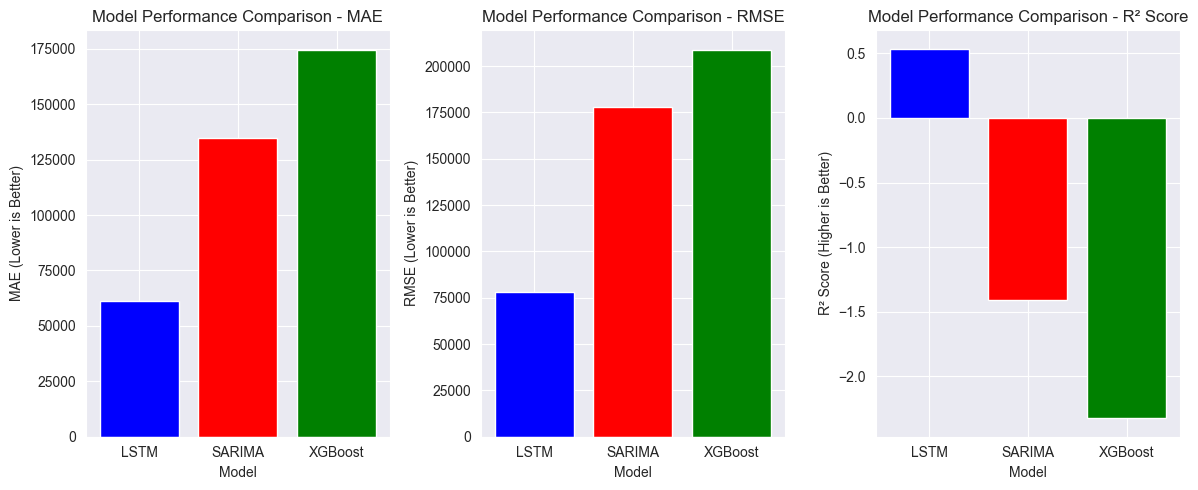

In [15]:
# Create DataFrame for results
results = pd.DataFrame({
    "Model": ["SARIMA", "XGBoost", "LSTM"],
    "MAE": [sarima_mae, xgb_mae, lstm_mae],
    "RMSE": [sarima_rmse, xgb_rmse, lstm_rmse],
    "R² Score": [sarima_r2, xgb_r2, lstm_r2]
})

# Sort results by MAE for better visualization
results = results.sort_values(by="MAE")

# Display results
print(results)

# Plot the results
plt.figure(figsize=(12,5))

# MAE Comparison
plt.subplot(1,3,1)
plt.bar(results["Model"], results["MAE"], color=["blue", "red", "green"])
plt.xlabel("Model")
plt.ylabel("MAE (Lower is Better)")
plt.title("Model Performance Comparison - MAE")

# RMSE Comparison
plt.subplot(1,3,2)
plt.bar(results["Model"], results["RMSE"], color=["blue", "red", "green"])
plt.xlabel("Model")
plt.ylabel("RMSE (Lower is Better)")
plt.title("Model Performance Comparison - RMSE")

# R² Score Comparison
plt.subplot(1,3,3)
plt.bar(results["Model"], results["R² Score"], color=["blue", "red", "green"])
plt.xlabel("Model")
plt.ylabel("R² Score (Higher is Better)")
plt.title("Model Performance Comparison - R² Score")

plt.tight_layout()
plt.show()

## Conclusion
* LSTM is the best model for e-commerce sales forecasting, achieving the lowest MAE (59,553) and the highest R² (0.561).
* SARIMA struggles to explain variance in sales (R² = -1.41) despite handling seasonality well.
* XGBoost completely fails (R² = -2.33) and is not suitable for this dataset.
* Future research should explore combining SARIMA + LSTM to improve forecasting accuracy.